# Bio-inspired computing algorithms

### A whirdwind tour

#### Quentin Caudron

For "simple" problems, we humans can dream up a solution using mathematics.

> Let's assume my data, $y$, is linear in $x$. That is, $y = \alpha + \beta\,x$. What are $\alpha$ and $\beta$ ?

1. Assume measurements are noisy : $y_i = \alpha + \beta\,x + \varepsilon_i$.
2. Minimise $\displaystyle \sum_{i=1}^{N} \varepsilon_i^2 = \sum_{i=1}^{N} \big(y_i - \alpha - \beta\,x_i\big)^2$ over $\alpha$ and $\beta$
3. [Do some calculus](https://en.wikipedia.org/wiki/Simple_linear_regression)
4. $\displaystyle \hat{\beta} = \frac{\mathrm{Cov}(x, y)}{\mathrm{Var}(x)}$ and $\displaystyle \hat{\alpha} = \bar{y} - \hat{\beta}\,\bar{x}$

For "more complicated" problems, sometimes we can throw raw compute power at the problem.

> Suppose I give you a positive number. Is it prime ?

In [1]:
number = 20173
for i in range(2, number):
    if number % i == 0:
        print("Number is not prime ( divisible by {} ).".format(i))
        break
    if i == number - 1:
        print("Number is prime !")

Number is prime !


Sometimes, we get very inventive with our solutions, shrinking the space of things to search through, making things run much faster.

> Given the sorted array [1, 4, 5, 9, 124, 378, 1024, 7473], in which position is the number 9 ?

A basic search, where we just iterate through the array until we find the target value, runs in $\mathcal{O}(n)$ worst case time complexity. [Binary search](https://en.wikipedia.org/wiki/Binary_search_algorithm), which "intelligently" jumps around the array from the middle, runs in $\mathcal{O}(\log{n})$ time.

In looking for solutions to complex problems, **nature can provide inspiration**.

<img src="images/neural_net.jpg" width="800px" />

## What is bio-inspired computing ?

[Algorithms](https://en.wikipedia.org/wiki/Bio-inspired_computing) inspired by the natural world - evolution, the brain, animal ecologies, and other areas. Examples include :

- evolutionary algorithms
- artificial neural networks
- swarm intelligence algorithms
- artificial immune systems

These algorithms take advantage of the phenomenon of **[emergence](https://en.wikipedia.org/wiki/Emergence)** in complex systems.

## Emergence

> **emergence** is a phenomenon whereby larger entities arise through interactions among smaller or simpler entities such that the larger entities exhibit properties the smaller/simpler entities do not exhibit.

> -- Wikipedia

**The sum is greater than the parts** ( a concept central to complex systems theory ).

### Swarming

<img src="images/starlings.jpg" width="600px" />

### Pattern formation ( emergent structure )

<img src="images/dunes.jpg" width="600px" />

### Synchronisation

<img src="images/fireflies.jpg" width="600px" />

### Complex phenomena

<img src="images/brain.jpg" width="600px" />

## Emergence : the Angels and Mortals game

Based on [this paper](https://arxiv.org/abs/adap-org/9912005) : we live in a square, discrete grid, populated by Angels and Mortals. 

**Initialisation**
- The density of Angels is $D_A$, and that of Mortals is $D_M$
- Because this is a realistic world, $D_M \gg D_A$

**Simulation**
- Both agents move one square on the grid at each timestemp
- Mortals die every timestep with probability $\mu$
- When a Mortal has an Angel in their immediate environment, they reproduce with probability $\lambda$

### Classically speaking...

If we assume mass-action kinetics, then the density of Mortals :

- drops due to death at a rate $\mu\,D_M$ 
- increases due to reproduction at a rate $\lambda \,D_A \,D_M$

As such :

$$\displaystyle \frac{\mathrm{d}D_M}{\mathrm{d}t} = \big(\lambda \, D_A - \mu\big) \, D_M$$

### The fate of Mortals

$$\displaystyle \frac{\mathrm{d}D_M}{\mathrm{d}t} = \big(\lambda \, D_A - \mu\big) \, D_M$$

The solution to this differential equation is 

$$\displaystyle D_M(t) = D_M(0) \,e^{\,t\,\large(\,\lambda\,D_A \,-\, \mu\, \large)}$$

Therefore, if $\mu > \lambda\,D_A$, then $$\displaystyle \lim_{t \to \infty} D_M = 0.$$

Let's test our mass-action assumption.

In [9]:
import numpy as np
from scipy.signal import convolve
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
import seaborn as sns
from tqdm import tqdm_notebook, tnrange

In [3]:
# System parameters
gridsize = 100
angel_density = 0.0005
mortal_density = 0.05
reproduction_rate = 0.2
death_rate = 0.05


# Agent : parent class containing init and move methods
class Agent(object):
    
    def __init__(self, gridsize):
        """Randomly place the agent on the grid."""
        self.gridsize = gridsize
        self.x = np.random.randint(0, gridsize)
        self.y = np.random.randint(0, gridsize)
        
    def move(self):
        """Move the agent to a random nearby square."""
        self.x = (self.x + np.random.randint(-1, 2)) % self.gridsize
        self.y = (self.y + np.random.randint(-1, 2)) % self.gridsize
        
    def look_nearby(self, grid):
        """Return the number of angels and mortals nearby."""
        nearby_mortals = grid[self.x-1:self.x+1, self.y-1:self.y+1, 0].sum()
        nearby_angels = grid[self.x-1:self.x+1, self.y-1:self.y+1, 2].sum()
        return nearby_mortals, nearby_angels
        

# Mortals are Agents with an added possibility of death
class Mortal(Agent):
    
    def __init__(self, gridsize, death_rate, coordinates=None):
        """Save the death rate; optionally place the Mortal in the given location."""
        
        super().__init__(gridsize)
        self.death_rate = death_rate
        
        if coordinates:
            self.x, self.y = coordinates
        
    @property
    def is_dead(self):
        """Return True if the mortal has passed away."""
        if np.random.rand() < self.death_rate:
            return True
        return False
        
        
class Angel(Agent):
    
    def __init__(self, gridsize, reproduction_rate):
        """Call the parent's init, and save the reproduction rate."""
        super().__init__(gridsize)
        self.reproduction_rate = reproduction_rate


def make_grid(gridsize, angels, mortals):
    """Take lists of angels and mortals, and place them on the grid."""
    
    grid = np.zeros((gridsize, gridsize, 3))
    
    for mortal in mortals:
        grid[mortal.x, mortal.y, 0] += 1
    for angel in angels:
        grid[angel.x, angel.y, 2] += 1
    
    return grid


def initialise(gridsize, angel_density, mortal_density, reproduction_rate, death_rate):
    """Set up a system of angels and mortals on a grid."""
    
    # Set up angels and mortals lists
    angels = [Angel(gridsize, reproduction_rate) for _ in np.arange(angel_density * gridsize**2)]
    mortals = [Mortal(gridsize, death_rate) for _ in np.arange(mortal_density * gridsize**2)]
    
    # Place them on the grid
    grid = make_grid(gridsize, angels, mortals)

    return grid, angels, mortals


def reproduce(grid, angels, mortals):
    """Mortals reproduce with nearby angels."""
    
    # For each angel
    for angel in angels:
        
        # Find nearby mortals
        nearby_mortals, _ = angel.look_nearby(grid)
    
        # Determine the number of new mortals spawned by reproduction
        new_mortals = np.random.binomial(nearby_mortals, angel.reproduction_rate)
        
        # Create the mortals in the local environment
        if grid[:, :, 0].sum() < 1000:
            for new_mortal in range(new_mortals):
                coordinates = ((angel.x + np.random.randint(-1, 2)) % grid.shape[0], 
                               (angel.y + np.random.randint(-1, 2)) % grid.shape[0])
                mortals.append(Mortal(gridsize, death_rate, coordinates=coordinates))
        
    grid = make_grid(gridsize, angels, mortals)
    
    return grid, angels, mortals


def grim_reaper(grid, angels, mortals):
    """Kill off mortals."""

    # Remove dead mortals
    mortals = [mortal for mortal in mortals if not mortal.is_dead]
    
    grid = make_grid(grid.shape[0], angels, mortals)
    return grid, angels, mortals
        
    
def advance_sytem(grid, angels, mortals):
    """Advance the system one timestep."""
    
    # Move all agents
    for angel in angels:
        angel.move()
    for mortal in mortals:
        mortal.move()
        
    # Angels and mortals in nearby squares reproduce
    grid, angels, mortals = reproduce(grid, angels, mortals)
    
    # Mortals die randomly
    grid, angels, mortals = grim_reaper(grid, angels, mortals)
    
    return grid, angels, mortals


def run_simulation(rounds, gridsize, angel_density, mortal_density, reproduction_rate, death_rate):
    """Run a number of simulations, and return the number of mortals left surviving at the end."""
    
    if death_rate < reproduction_rate * angel_density:
        survive = True
    else:
        survive = False
    
    # Initialise
    grid, angels, mortals = initialise(gridsize, angel_density, mortal_density, reproduction_rate, death_rate)
    
    # Move the simulation forwards, saving the number of mortals
    number_mortals = [grid[:, :, 0].sum()]
    for _ in range(rounds):
        grid, angels, mortals = advance_sytem(grid, angels, mortals)
        number_mortals.append(grid[:, :, 0].sum())
        if number_mortals[-1] > 1000:
            break
        
    return number_mortals, survive


def reproduction_rate_sweep(reproduction_rates=np.linspace(0.5, 1, 6), gridsize=50, angel_density=0.001,
                            mortal_density=0.05, death_rate=0.03, rounds=200):
    """Sweep over reproduction rates 0.5 - 1 and plot the results."""
    
    results = {}
    survives = {}
    for rep_rate in tqdm_notebook(reproduction_rates, desc="Rates"):
        results[rep_rate] = []
        for _ in tnrange(10, leave=False, desc="Reps"):
            sim, survival = run_simulation(rounds, gridsize, angel_density, mortal_density, rep_rate, death_rate)
            results[rep_rate].append(sim)
            survives[rep_rate] = survival
            
    plt.figure(figsize=(10, 6))
    for i in range(2):
        for j in range(3):
            plt.subplot(2, 3, i * 3 + j + 1)
            plt.xlim(0, rounds)
            plt.title("$\lambda = {}$; {} expected".format(
                reproduction_rates[i * 3 + j], 
                    "survival" if survives[reproduction_rates[i * 3 + j]] else "die out"))
            for result in results[reproduction_rates[i * 3 + j]]:
                plt.plot(result)
    plt.tight_layout()

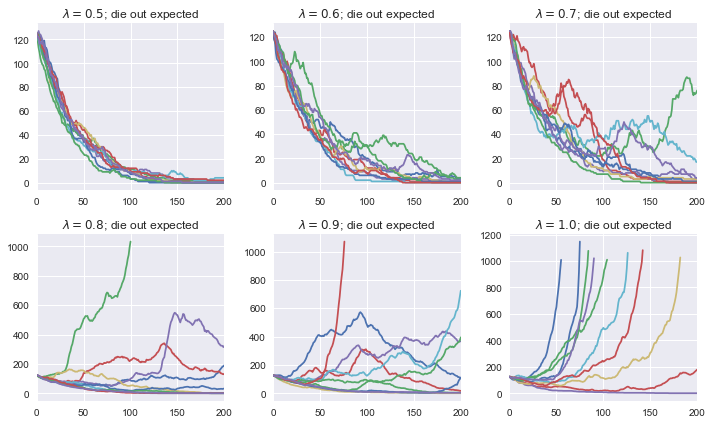

In [6]:
# What do the simulations say ?
reproduction_rate_sweep(angel_density=0.002, death_rate=0.03)

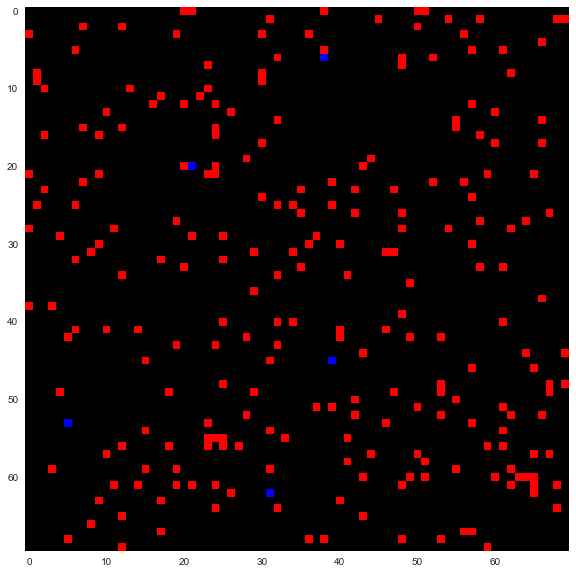

In [11]:
gridsize = 70
angel_density = 0.001
mortal_density = 0.05
reproduction_rate = 1
death_rate = 0.03

grid, angels, mortals = initialise(gridsize, angel_density, mortal_density, reproduction_rate, death_rate)


fig = plt.figure(figsize=(10, 10))
plt.grid(0)
im = fig.gca().imshow(grid, animated=True)


def updatefig(*args):
    global grid, angels, mortals
    grid, angels, mortals = advance_sytem(grid, angels, mortals)
    im.set_array(grid)
    return im,


In [12]:
# What does it look like ?
ani = animation.FuncAnimation(fig, updatefig, interval=40, frames=300, blit=True)
HTML(ani.to_html5_video())

## So, emergence...

Complex behaviours in systems arise as a result of the simple interactions of the system's many parts.

## Order out of chaos

Bio-inspired computing algorithms leverage the collective intelligence that emerges from complex systems. 

This approach has led to a number of very successful methods in computing, like **neural networks** and **genetic algorithms**. Such algorithms can be successfully used to solve in difficult optimisation tasks. 